# Minimax Linkage 

There is no minimax linkage implemented in ```scipy.cluster.hierarchy``` as of Feb 2021. There is a standalone package [pyprotoclust](https://github.com/andgoldschmidt/pyprotoclust), possibly the only python package available for minimax linkage, but a simple pip install doesn't always work. 

Below is a brute force implementation. 

There is a nearest neighbor chain algorithm which is used in scipy for complete linkage. Minimax linkage can be implemented in the same way. 

The update rule of minimax linkage is

\begin{align*}
d(G_1 \cup G_2, H) = \min_{i\in G_1\cup G_2 \cup H} \max_{j\in G_1\cup G_2 \cup H} d_{ij}.
\end{align*}

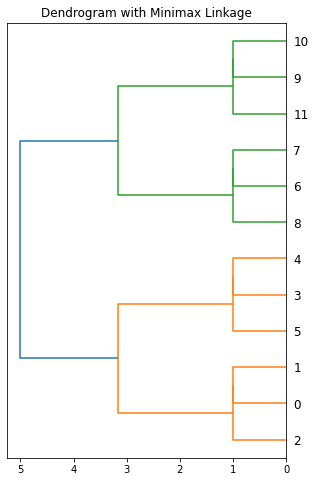

CPU times: user 1.09 s, sys: 195 ms, total: 1.28 s
Wall time: 1.38 s


,0,1,2,3
0,0,1,1.000000,2
1,2,12,1.000000,3
2,3,4,1.000000,2
3,5,14,1.000000,3
4,6,7,1.000000,2
5,8,16,1.000000,3
6,9,10,1.000000,2
7,11,18,1.000000,3
8,13,15,3.162278,6
9,17,19,3.162278,6


In [3]:
%%time

import math
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from pandas import DataFrame
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

def minimax_linkage(dist):
    n = int((np.sqrt(8*len(dist) + 1) + 1)/2)
    
    def d(i, j): return dist[n*i+j-((i+2)*(i+1))//2] if i<j else (0 if i==j else d(j, i))
    def r(i, G): return max(d(i, j) for j in G)
    
    Z = []
    clusters = {i: set([i]) for i in range(n)}
    for i in range(n-1):
        min_d = math.inf
        for (idxG, G), (idxH, H) in combinations(clusters.items(), 2):
            dminimax = min(r(x, G|H) for x in G|H)
            if dminimax < min_d:
                min_d = dminimax
                to_merge = [idxG, idxH, dminimax, len(G|H)]
        Z.append(to_merge)
        idxG, idxH, _, _ = to_merge
        clusters[n+i] = clusters.pop(idxG) | clusters.pop(idxH)
        
    return Z

X = [[0, 0], [0, 1], [1, 0], [0, 4], [0, 3], [1, 4], [4, 0], [3, 0], [4, 1], [4, 4], [3, 4], [4, 3]]
Z = minimax_linkage(pdist(X))
# Z = hierarchy.complete(pdist(X))

fig, ax = plt.subplots(1, 1, figsize=(5, 8))
hierarchy.dendrogram(Z, ax=ax, orientation='left')
ax.set(title='Dendrogram with Minimax Linkage')
plt.show()

DataFrame(Z)

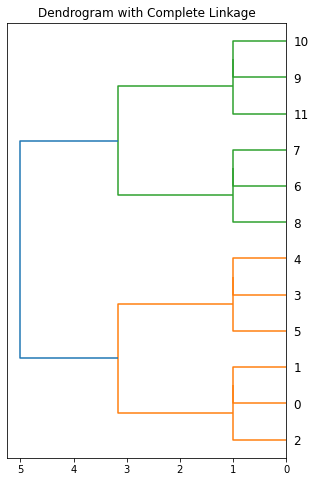

       0     1         2     3
0    0.0   1.0  1.000000   2.0
1    2.0  12.0  1.000000   3.0
2    3.0   4.0  1.000000   2.0
3    6.0   7.0  1.000000   2.0
4    5.0  14.0  1.000000   3.0
5    8.0  15.0  1.000000   3.0
6    9.0  10.0  1.000000   2.0
7   11.0  18.0  1.000000   3.0
8   13.0  16.0  3.162278   6.0
9   17.0  19.0  3.162278   6.0
10  20.0  21.0  5.000000  12.0


In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist


class LinkageUnionFind:
    """Structure for fast cluster labeling in unsorted dendrogram."""
#     cdef int[:] parent
#     cdef int[:] size
#     cdef int next_label

    def __init__(self, n):
        self.parent = np.arange(2 * n - 1)
        self.next_label = n
        self.size = np.ones(2 * n - 1)

    def merge(self, x, y):
        self.parent[x] = self.next_label
        self.parent[y] = self.next_label
        size = self.size[x] + self.size[y]
        self.size[self.next_label] = size
        self.next_label += 1
        return size

    def find(self, x):
        p = x

        while self.parent[x] != x:
            x = self.parent[x]

        while self.parent[p] != x:
            p, self.parent[p] = self.parent[p], x

        return x


def label(Z, n):
    """Correctly label clusters in unsorted dendrogram."""
    uf = LinkageUnionFind(n)
    for i in range(n - 1):
        x, y = int(Z[i, 0]), int(Z[i, 1])
        x_root, y_root = uf.find(x), uf.find(y)
        if x_root < y_root:
            Z[i, 0], Z[i, 1] = x_root, y_root
        else:
            Z[i, 0], Z[i, 1] = y_root, x_root
        Z[i, 3] = uf.merge(x_root, y_root)
        


def condensed_index(n, i, j):
    """
    Calculate the condensed index of element (i, j) in an n x n condensed
    matrix.
    """
    if i < j:
        return int(round(n * i - (i * (i + 1) / 2) + (j - i - 1)))
    elif i > j:
        return int(round(n * j - (j * (j + 1) / 2) + (i - j - 1)))

    
# def nn_chain(dists, n, method):
def minimax(dists):
    """Perform hierarchy clustering using nearest-neighbor chain algorithm.
    Parameters
    ----------
    dists : ndarray
        A condensed matrix stores the pairwise distances of the observations.
    Returns
    -------
    Z : ndarray, shape (n - 1, 4)
        Computed linkage matrix.
    """
    n = int((np.sqrt(8*len(dists) + 1) + 1)/2)
    
    Z_arr = np.empty((n - 1, 4))
    Z = Z_arr

    D = dists.copy()  # Distances between clusters.
    size = np.ones(n, dtype=np.intc)  # Sizes of clusters.
    
    indices = [set([i]) for i in range(n)]

#     new_dist = linkage_methods[method]

    # Variables to store neighbors chain.
    cluster_chain = np.ndarray(n, dtype=np.intc)
    chain_length = 0

#     cdef int i, j, k, x, y, nx, ny, ni
#     cdef double dist, current_min

    for k in range(n - 1):
        if chain_length == 0:
            chain_length = 1
            for i in range(n):
                if size[i] > 0:
                    cluster_chain[0] = i
                    break

        # Go through chain of neighbors until two mutual neighbors are found.
        while True:
            x = cluster_chain[chain_length - 1]

            # We want to prefer the previous element in the chain as the
            # minimum, to avoid potentially going in cycles.
            if chain_length > 1:
                y = cluster_chain[chain_length - 2]
                current_min = D[condensed_index(n, x, y)]
            else:
                current_min = np.inf   # NPY_INFINITYF

            for i in range(n):
                if size[i] == 0 or x == i:
                    continue
                
                dist = D[condensed_index(n, x, i)]
                if dist < current_min:
                    current_min = dist
                    y = i

            if chain_length > 1 and y == cluster_chain[chain_length - 2]:
                break

            cluster_chain[chain_length] = y
            chain_length += 1

        # Merge clusters x and y and pop them from stack.
        chain_length -= 2

        # This is a convention used in fastcluster.
        if x > y:
            x, y = y, x

        # get the original numbers of points in clusters x and y
        nx = size[x]
        ny = size[y]

        # Record the new node.
        Z[k, 0] = x
        Z[k, 1] = y
        Z[k, 2] = current_min
        Z[k, 3] = nx + ny
        size[x] = 0  # Cluster x will be dropped.
        size[y] = nx + ny  # Cluster y will be replaced with the new cluster

        indices[y] |= indices[x]
        indices[x] = set()

        # Update the distance matrix.
        for i in range(n):
            ni = size[i]
            if ni == 0 or i == y:
                continue
                
            # D[condensed_index(n, i, y)] = max(D[condensed_index(n, i, x)], D[condensed_index(n, i, y)])  # complete linkage
            
            all_indices = indices[y] | indices[i]
            D[condensed_index(n, i, y)] = min(max(dists[condensed_index(n, j, k)] if j!=k else 0 for k in all_indices) for j in all_indices)  # minimax linkage, 實測先抄到 np.array 再取 minmax 反而更慢

    # Sort Z by cluster distances.
    order = np.argsort(Z_arr[:, 2], kind='mergesort')
    Z_arr = Z_arr[order]

    # Find correct cluster labels inplace.
    label(Z_arr, n)

    return Z_arr


X = [[0, 0], [0, 1], [1, 0], [0, 4], [0, 3], [1, 4], [4, 0], [3, 0], [4, 1], [4, 4], [3, 4], [4, 3]]
Z = minimax(pdist(X))

fig, ax = plt.subplots(1, 1, figsize=(5, 8))
hierarchy.dendrogram(Z, ax=ax, orientation='left')
ax.set(title='Dendrogram with Complete Linkage')
plt.show()

print(DataFrame(Z))

In [11]:
%%timeit

# using np.max and np.min

import numpy as np

n = 100
np.random.seed(0)
X = np.random.rand(n, 2)
Z = minimax(pdist(X))

874 ms ± 92.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
%%timeit

# using python built-in

import numpy as np

n = 100

np.random.seed(0)
X = np.random.rand(n, 2)
Z = minimax(pdist(X))

504 ms ± 23.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


CPU times: user 2min 32s, sys: 127 ms, total: 2min 32s
Wall time: 2min 33s


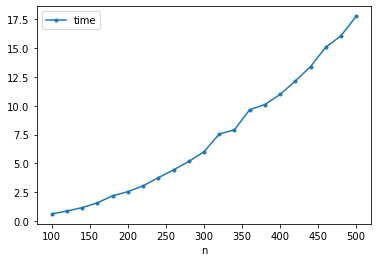

In [2]:
%%time

import time
import numpy as np
from pandas import DataFrame

np.random.seed(0)
n_pts = np.arange(100, 501, 20)
elapsed_time = []

def test_run(n):
    X = np.random.rand(n, 2)
    Z = minimax(pdist(X))    

for n in n_pts:
    t = time.process_time()
    test_run(n)
    elapsed_time.append(time.process_time() - t)
    
df = DataFrame({'n': n_pts, 'time': elapsed_time}).set_index('n')
df.plot(style='.-')
pass

In [3]:
df

,time
n,
100,0.618942
120,0.868634
140,1.165988
160,1.584192
180,2.195476
200,2.550525
220,3.055468
240,3.760503
260,4.438697


In [5]:
from pandas import DataFrame

n = len(X)

DataFrame([[condensed_index(12, i, j) if i>j else '' for j in range(12)] for i in range(12)])

,0,1,2,3,4,5,6,7,8,9,10,11
0,,,,,,,,,,,,
1,0,,,,,,,,,,,
2,1,11,,,,,,,,,,
3,2,12,21,,,,,,,,,
4,3,13,22,30,,,,,,,,
5,4,14,23,31,38,,,,,,,
6,5,15,24,32,39,45,,,,,,
7,6,16,25,33,40,46,51,,,,,
8,7,17,26,34,41,47,52,56,,,,
9,8,18,27,35,42,48,53,57,60,,,
